In [1]:
# packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
from math import sqrt, log
from sklearn.metrics import make_scorer


# Introduction

In [2]:
# Load training and test data
train_data = pd.read_csv('../cleaned_data/train_data_simple_clean.csv')
test_data = pd.read_csv('../cleaned_data/test_data_simple_clean.csv')
                         
# Identify target variable and drop it from 
target = train_data['SalePrice']
X = train_data.drop(['SalePrice', 'Id'], axis = 1)

# Preview Data
display(train_data.tail())
display(test_data.head())

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0.0,...,0,0,1,0,0,0,0,1,0,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790.0,...,0,0,1,0,0,0,0,1,0,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275.0,...,0,0,1,0,0,0,0,1,0,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49.0,...,0,0,1,0,0,0,0,1,0,142125
1459,1460,20,75.0,9937,5,6,1965,1965,0.0,830.0,...,0,0,1,0,0,0,0,1,0,147500


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,1,0,0,0,0,1,0
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,0,0,0,1,0,0,0,0,1,0
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,0,0,0,1,0,0,0,0,1,0


In [3]:
# function to ensure no negative values are predited
def pos_func(a):
    if (a > 0): return a
    else: return 0
pos_func = np.vectorize(pos_func)

# Scoring function.
# In order to test for kaggle score we must create a function to score predictions as they are scored in the competition rules
def rmse_log(values, predictions):
    delta_preds = pos_func(predictions)

    log_vals = np.log1p(values)
    log_preds = np.log1p(delta_preds)
    
    return sqrt(mean_squared_error(log_vals, log_preds))

In [4]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.3)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

display(X_train.head())

X_train : (1022, 288)
X_test : (438, 288)
y_train : (1022,)
y_test : (438,)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
631,120,34.0,4590,8,5,2006,2006,108.0,24.0,0.0,...,0,0,0,1,0,0,0,0,1,0
279,60,83.0,10005,7,5,1977,1977,299.0,392.0,0.0,...,0,0,0,1,0,0,0,0,1,0
740,70,60.0,9600,5,7,1910,2002,0.0,0.0,0.0,...,0,0,0,1,1,0,0,0,0,0
110,50,75.0,9525,6,4,1954,1972,0.0,444.0,0.0,...,0,0,0,1,0,0,0,0,1,0
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0


## Linear Regression

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
The R-squared on the training set is 0.9413
The R-squared on the test set is 0.8437
--------------------------------------------------
The MSE on the training set is 0.10
The MSE on the test set is 0.20


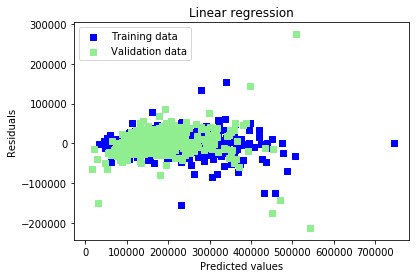

In [26]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# get preditictions for training and test set.
y_train_pred = pos_func(lr.predict(X_train))
y_test_pred = pos_func(lr.predict(X_test))


print(type(y_train_pred))
print(type(y_train))

# R-squared
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# RMSE of log of Sale Price
train_rmse = rmse_log(y_train, y_train_pred)
test_rmse = rmse_log(y_test, y_test_pred)

# display model fit metrics.
print(f"The R-squared on the training set is {train_r2:,.4f}")
print(f"The R-squared on the test set is {test_r2:,.4f}")
print('-' * 50)
print(f"The MSE on the training set is {train_rmse:,.2f}")
print(f"The MSE on the test set is {test_rmse:,.2f}")


# residuals
train_resids = y_train_pred - y_train
test_resids = y_test_pred - y_test

# Plot residuals
plt.scatter(y_train_pred, train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()


In [6]:
# predictions for competitiion submission
model_predicts = pos_func(lr.predict(test_data.drop('Id', axis = 1)))

reg_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':model_predicts})
reg_submission = reg_submission.set_index('Id')

# preview submission to ensure format is correct.
display(reg_submission.head())

# 
#reg_submission.to_csv('../submissions/basic_regression.csv')

,SalePrice
Id,
1461,142146.773084
1462,182511.969176
1463,187826.130120
1464,204232.363518
1465,205055.926857


## Ridge Regression

Training set r_2 score: 0.898196
Test set r_2 score: 0.875876
--------------------------------------------------
Training set log rmse score: 0.126986
Test set log rmse score: 0.143593


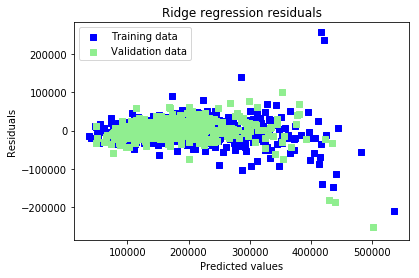

In [7]:
# simple ridge regression using default value of alpha
# a later extension is to use grid search.
ridge_model = Ridge(alpha = 10).fit(X_train, y_train)

# predictions for training and test set.
ridge_train_pred = pos_func(ridge_model.predict(X_train))
ridge_test_pred = pos_func(ridge_model.predict(X_test))

# RMSE of log of Sale Price
ridge_train_rmse = rmse_log(y_train, ridge_train_pred)
ridge_test_rmse = rmse_log(y_test, ridge_test_pred)

# display model fit metrics.
print('Training set r_2 score: {:2f}'.format(ridge_model.score(X_train, y_train)))
print('Test set r_2 score: {:2f}'.format(ridge_model.score(X_test, y_test)))
print('-' * 50)
print('Training set log rmse score: {:2f}'.format(ridge_train_rmse))
print('Test set log rmse score: {:2f}'.format(ridge_test_rmse))

# residuals
ridge_train_resids = ridge_train_pred - y_train
ridge_test_resids = ridge_test_pred - y_test

# Plot residuals
plt.scatter(ridge_train_pred, ridge_train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(ridge_test_pred, ridge_test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Ridge regression residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()


In [8]:
# predictions for competition entry.
ridge_predicts = pos_func(ridge_model.predict(test_data.drop('Id', axis = 1)))
ridge_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':ridge_predicts})
ridge_submission = ridge_submission.set_index('Id')

# preview submission
display(ridge_submission.head())

# ridge_submission.to_csv('../submissions/ridge_regression.csv')

,SalePrice
Id,
1461,112807.803952
1462,155384.551854
1463,172102.779483
1464,187626.000052
1465,209465.315243


Best parameters: {'alpha': 50}
Best cross-validation score: 0.16098315622859707
Test set score: 0.1408414286841155


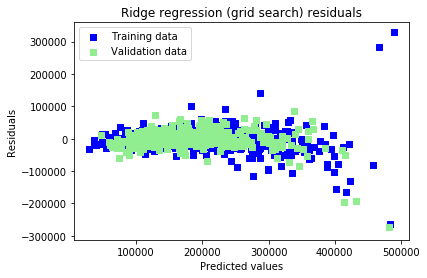

In [9]:
# now lets do a grid search to try improve our score
param_grid = {'alpha' : [0.001, 0.01, 0.1, 1, 10, 25,  50, 75, 100]}

# create scoring function to be used in grid search
my_scorer = make_scorer(rmse_log, greater_is_better = False)

# create grid search and fit
ridge_grid_search = GridSearchCV(Ridge(), param_grid, cv = 5, scoring = my_scorer)
ridge_grid_search.fit(X_train, y_train)

# display model fit parameters.
print('Best parameters: {}'.format(ridge_grid_search.best_params_))
print('Best cross-validation score: {}'.format(-ridge_grid_search.best_score_))
print('Test set score: {}'.format(-ridge_grid_search.score(X_test, y_test)))

# predictions for training and test set.
ridge_train_pred = pos_func(ridge_grid_search.predict(X_train))
ridge_test_pred = pos_func(ridge_grid_search.predict(X_test))


# residuals
ridge_train_resids = ridge_train_pred - y_train
ridge_test_resids = ridge_test_pred - y_test

# Plot residuals
plt.scatter(ridge_train_pred, ridge_train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(ridge_test_pred, ridge_test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Ridge regression (grid search) residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()


In [10]:
# predictions for comp entry.
ridge_grid_predicts = pos_func(ridge_grid_search.predict(test_data.drop('Id', axis = 1)))
ridge_grid_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':ridge_grid_predicts})
ridge_grid_submission = ridge_grid_submission.set_index('Id')

# preview submission
display(ridge_grid_submission.head())

# ridge_grid_submission.to_csv('../submissions/ridge_grid_regression.csv')

,SalePrice
Id,
1461,114106.285791
1462,151726.208951
1463,173859.733081
1464,193446.881446
1465,201190.738117


## Lasso Regression

Training set r_2 score: 0.930510
Test set r_2 score: 0.883501
--------------------------------------------------
Training set log rmse score: 0.134909
Test set log rmse score: 0.140841


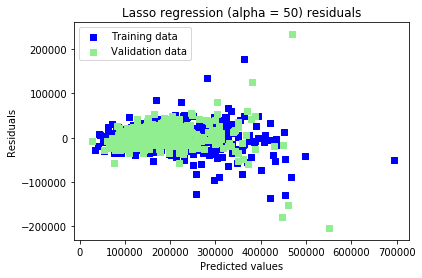

In [11]:
# simple Lasso regression using default value of alpha
# a later extension is to use grid search.
lasso_model = Lasso(alpha = 50, max_iter=100000).fit(X_train, y_train)

# predictions for training and test set.
lasso_train_pred = pos_func(lasso_model.predict(X_train))
lasso_test_pred = pos_func(lasso_model.predict(X_test))

# RMSE of log of Sale Price
lasso_train_rmse = rmse_log(y_train, ridge_train_pred)
lasso_test_rmse = rmse_log(y_test, ridge_test_pred)

# display model fit metrics.
print('Training set r_2 score: {:2f}'.format(lasso_model.score(X_train, y_train)))
print('Test set r_2 score: {:2f}'.format(lasso_model.score(X_test, y_test)))
print('-' * 50)
print('Training set log rmse score: {:2f}'.format(lasso_train_rmse))
print('Test set log rmse score: {:2f}'.format(lasso_test_rmse))

# residuals
lasso_train_resids = lasso_train_pred - y_train
lasso_test_resids = lasso_test_pred - y_test

# Plot residuals
plt.scatter(lasso_train_pred, lasso_train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(lasso_test_pred, lasso_test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Lasso regression (alpha = 50) residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()

In [12]:
# predictions for comp entry
lasso_predicts = pos_func(lasso_model.predict(test_data.drop('Id', axis = 1)))
lasso_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':lasso_predicts}).set_index('Id')
display(lasso_submission.head())

#lasso_submission.to_csv('../submissions/lasso_regression.csv')

,SalePrice
Id,
1461,127486.470787
1462,164765.830352
1463,180166.871243
1464,195735.654545
1465,213820.462621


Best parameters: {'alpha': 125}
Best cross-validation score: 0.15250683201307247
Test set score: 0.1281960501668512


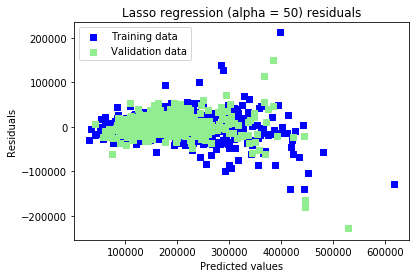

In [13]:
# now let's add a grid search to try improve our score.
# parameter grid to search over.
param_grid = {'alpha' : [50, 75, 100, 125, 150, 175, 400, 1000]}

# grid search and fit lasso
lasso_grid_search = GridSearchCV(Lasso(max_iter=100000), param_grid, cv = 5, scoring = my_scorer)
lasso_grid_search.fit(X_train, y_train)


print('Best parameters: {}'.format(lasso_grid_search.best_params_))
print('Best cross-validation score: {}'.format(-lasso_grid_search.best_score_))
print('Test set score: {}'.format(-lasso_grid_search.score(X_test, y_test)))


# predictions for training and test set.
lasso_train_pred = pos_func(lasso_grid_search.predict(X_train))
lasso_test_pred = pos_func(lasso_grid_search.predict(X_test))


# residuals
lasso_train_resids = lasso_train_pred - y_train
lasso_test_resids = lasso_test_pred - y_test

# Plot residuals
plt.scatter(lasso_train_pred, lasso_train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(lasso_test_pred, lasso_test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Lasso regression (alpha = 50) residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()

In [14]:
# predictions
lasso_grid_predicts = pos_func(lasso_grid_search.predict(test_data.drop('Id', axis = 1)))
lasso_grid_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':lasso_grid_predicts})
lasso_grid_submission = lasso_grid_submission.set_index('Id')

display(lasso_grid_submission.head())

#lasso_grid_submission.to_csv('../submissions/lasso_grid_regression.csv')

,SalePrice
Id,
1461,123469.566154
1462,159661.216315
1463,175638.251581
1464,194767.987782
1465,215333.637742


# Simple Regression Tree

Training set log rmse score: 0.000000
Test set log rmse score: 0.187928


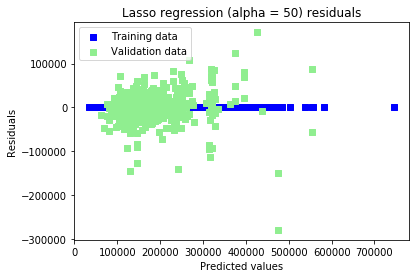

In [15]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor  
  
# create a regressor object 
reg_tree = DecisionTreeRegressor()  
  
# fit the regressor with X and Y data 
reg_tree.fit(X_train, y_train) 


# predictions for training and test set.
reg_tree_train_pred = (reg_tree.predict(X_train))
reg_tree_test_pred = pos_func(reg_tree.predict(X_test))


# RMSE of log of Sale Price
reg_tree_train_rmse = rmse_log(y_train, reg_tree_train_pred)
reg_tree_test_rmse = rmse_log(y_test, reg_tree_test_pred)

# display model fit metrics.
print('Training set log rmse score: {:2f}'.format(reg_tree_train_rmse))
print('Test set log rmse score: {:2f}'.format(reg_tree_test_rmse))


# residuals
reg_tree_train_resids = reg_tree_train_pred - y_train
reg_tree_test_resids = reg_tree_test_pred - y_test


# Plot residuals
plt.scatter(reg_tree_train_pred, reg_tree_train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(reg_tree_test_pred, reg_tree_test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Lasso regression (alpha = 50) residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()

In [16]:
# predictions
reg_tree_predicts = pos_func(reg_tree.predict(test_data.drop('Id', axis = 1)))
reg_tree_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':reg_tree_predicts})
reg_tree_submission = reg_tree_submission.set_index('Id')

display(reg_tree_submission.head())

#reg_tree_submission.to_csv('../submissions/reg_tree_regression.csv')

,SalePrice
Id,
1461,120500.0
1462,155000.0
1463,183200.0
1464,183200.0
1465,197000.0


# XGBoost

In [17]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)



C:\Users\marko\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

Training set log rmse score: 0.089415
Test set log rmse score: 0.127004


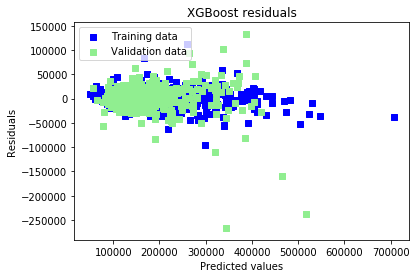

In [18]:
# predictions for training and test set.
xgb_train_pred = (model_xgb.predict(X_train))
xgb_test_pred = pos_func(model_xgb.predict(X_test))


# RMSE of log of Sale Price
xgb_train_rmse = rmse_log(y_train, xgb_train_pred)
xgb_test_rmse = rmse_log(y_test, xgb_test_pred)

# display model fit metrics.
print('Training set log rmse score: {:2f}'.format(xgb_train_rmse))
print('Test set log rmse score: {:2f}'.format(xgb_test_rmse))


# residuals
xgb_train_resids = xgb_train_pred - y_train
xgb_test_resids = xgb_test_pred - y_test


# Plot residuals
plt.scatter(xgb_train_pred, xgb_train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(xgb_test_pred, xgb_test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("XGBoost residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()

Best parameters: {'eta': 0.1, 'max_depth': 4}
Best cross-validation score: 0.13959415409335316
Test set score: 0.12169170165330083


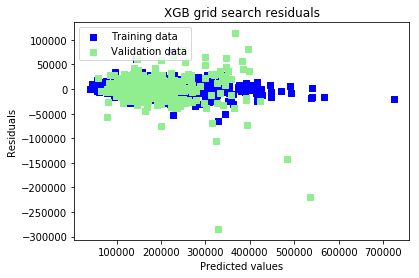

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

param_grid = {'max_depth' : [2, 4, 6], 
             'eta' : [0.1, 0.2, 0.3]}

# grid search and fit lasso
xgb_grid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv = 5, scoring = my_scorer)
xgb_grid_search.fit(X_train, y_train)


print('Best parameters: {}'.format(xgb_grid_search.best_params_))
print('Best cross-validation score: {}'.format(-xgb_grid_search.best_score_))
print('Test set score: {}'.format(-xgb_grid_search.score(X_test, y_test)))


# predictions for training and test set.
xgb_train_pred = pos_func(xgb_grid_search.predict(X_train))
xgb_test_pred = pos_func(xgb_grid_search.predict(X_test))


# residuals
xgb_train_resids = xgb_train_pred - y_train
xgb_test_resids = xgb_test_pred - y_test

# Plot residuals
plt.scatter(xgb_train_pred, xgb_train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(xgb_test_pred, xgb_test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("XGB grid search residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()

In [20]:
# predictions
xgb_grid_predicts = pos_func(xgb_grid_search.predict(test_data.drop('Id', axis = 1)))
xgb_grid_submission = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':xgb_grid_predicts})
xgb_grid_submission = xgb_grid_submission.set_index('Id')

display(xgb_grid_submission.head())

#xgb_grid_submission.to_csv('../submissions/xgb_grid_regression.csv')

,SalePrice
Id,
1461,129989.773438
1462,154121.250000
1463,177753.046875
1464,186188.343750
1465,189064.687500


# Ensemble Model

# Combine Lasso and XGBoost

In [21]:
# get features selected by Lasso Regression.

coef = pd.Series(lasso_model.coef_, index = X_train.columns)

print(len(coef))

coef = coef[coef != 0]


lasso_coef = list(coef.index)
print(lasso_coef)

288
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_C (all)', 'MSZoning_FV', 'MSZoning_RM', 'Street_Grvl', 'Street_Pave', 'Alley_Grvl', 'LotShape_IR1', 'LotShape_IR2', 'LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_Mitchel', 'Neighborh

Training set log rmse score: 0.092340
Test set log rmse score: 0.127275


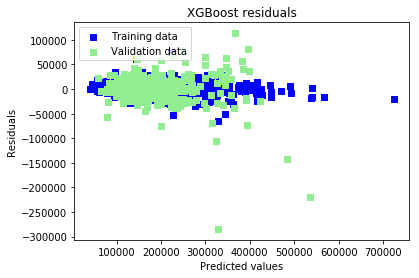

In [22]:
model_lasso_xgb = xgb.XGBRegressor()
model_lasso_xgb.fit(X_train[lasso_coef], y_train)


# predictions for training and test set.
xgb_lasso_train_pred = (model_lasso_xgb.predict(X_train[lasso_coef]))
xgb_lasso_test_pred = pos_func(model_lasso_xgb.predict(X_test[lasso_coef]))


# RMSE of log of Sale Price
xgb_train_rmse = rmse_log(y_train, xgb_lasso_train_pred)
xgb_test_rmse = rmse_log(y_test, xgb_lasso_test_pred)

# display model fit metrics.
print('Training set log rmse score: {:2f}'.format(xgb_train_rmse))
print('Test set log rmse score: {:2f}'.format(xgb_test_rmse))


# residuals
xgb_train_resids = xgb_train_pred - y_train
xgb_test_resids = xgb_test_pred - y_test


# Plot residuals
plt.scatter(xgb_train_pred, xgb_train_resids, c = "blue", marker = "s", label = "Training data")
plt.scatter(xgb_test_pred, xgb_test_resids, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("XGBoost residuals")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()

In [23]:
# predictions
xgb_lasso_predicts = pos_func(model_lasso_xgb.predict(test_data[lasso_coef]))
xgb_lasso_sub = pd.DataFrame({'Id':test_data['Id'], 'SalePrice':xgb_lasso_predicts})
xgb_lasso_sub = xgb_lasso_sub.set_index('Id')

display(xgb_lasso_sub.head())

#xgb_lasso_sub.to_csv('../submissions/xgb_lasso_sub.csv')

,SalePrice
Id,
1461,130116.265625
1462,159438.218750
1463,167383.578125
1464,178461.609375
1465,189648.421875


In [24]:
# weights to be used
w1 = 1/5
w2 = 2/5
w3 = 1/5
w4 = 2/5
ensemble_sub = (w2 * xgb_lasso_sub) + (w3 * lasso_grid_submission) + (w4 * xgb_grid_submission)

display(ensemble_sub.head())
#ensemble_sub.to_csv('../submissions/ensemble_sub.csv')

,SalePrice
Id,
1461,128736.331200
1462,157356.032325
1463,173182.298754
1464,184813.581931
1465,194551.969736
